In [1]:
from time import time

import pickle

import torch
import sklearn.datasets
import sklearn.preprocessing
import sklearn.model_selection
import numpy as np
import math
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST as FMNIST
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms

import onlinehd

device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(1234)
torch.manual_seed(1234)

# Prepare Neural Network

In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pylab as pl
from IPython import display
%matplotlib inline

# Dataset

In [3]:
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

class CustomImageDataset(Dataset):
    def __init__(self, df, data_type = 'train', model_type='ffnn'):
        """
        :param df: data frame
        :param rating_2014_file: 'train'/'test'
        :param model_type: 'ffnn'/'cnn'
        """
        if data_type == 'train':
            self.X = df.drop('label', axis=1).values/255.
            self.Y = df['label'].values
        else:
            self.X = df.values/255.
            self.Y = None
        self.X = torch.from_numpy(self.X.astype(np.float32)).reshape(len(df),28, 28)
        self.data_type = data_type
        self.model_type = model_type

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        image = self.X[idx]
        if self.data_type == 'train':
            label = self.Y[idx]
        else:
            label = None
        
        if self.model_type == 'ffnn':
            return image, label
        else:
            # add additional dimension if we need dataset for cnn
            return image.unsqueeze(0), label

In [4]:
x, y = sklearn.datasets.fetch_openml('mnist_784', return_X_y=True)
x = x.astype(np.float)
y = y.astype(np.int)
y = np.array(y)

x, x_test, y, y_test = sklearn.model_selection.train_test_split(x, y)

x['label'] = y
x_test['label'] = y_test

/var/folders/4_/4812b_4j2_s0smfmxlqdpr600000gn/T/ipykernel_10620/3224256213.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = x.astype(np.float)
/var/folders/4_/4812b_4j2_s0smfmxlqdpr600000gn/T/ipykernel_10620/3224256213.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://nu

In [5]:
df_train = x
df_val = x_test

Feature batch shape: torch.Size([128, 28, 28])
Labels batch shape: torch.Size([128])


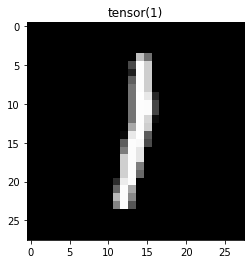

In [6]:
BATCH_SIZE = 128
EPOCHS = 30

# load dataa
# df_train, df_val = train_test_split(df, test_size=0.2)

# create Dataset
training_data = CustomImageDataset(df_train)
valid_data = CustomImageDataset(df_val)

# create Dataloader
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.title(label)
plt.show()

# Network

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# convolutional nn
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # input torch.Size([64, 1, 28, 28])
        # torch.Size([batch_size, channels, img_width, img_height])
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4)
        # torch.Size([64, 16, 28-kernel_size+1, 28-kernel_size+1])
        # torch.Size([64, 16, 25, 25])
        self.relu1=nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=2)
        
        # torch.Size([64, 8, 24, 24])
        self.relu2=nn.ReLU()
        self.max_pool2=nn.MaxPool2d(kernel_size=2)
        
        # torch.Size([64, 8, 12, 12])
        self.fc1 = nn.Linear(8*12*12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        
        out=self.conv1(x)
        out=self.relu1(out)
        
        out=self.conv2(out)
        out=self.relu2(out)
        out=self.max_pool2(out)
        
        out = torch.flatten(out, 1)
        out=self.fc1(out)
        out=self.fc2(out)
        return out

In [8]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn, result_dict):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    result_dict['avg_loss'].append(test_loss)
    result_dict['acc'].append(correct)
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
def plot_results(axs, res_dict):
    
    axs[0].plot(res_dict['epoch'][-10:], res_dict['acc'][-10:], c='r')
    axs[0].set_title('Validation accuracy {:.4f}'.format(res_dict['acc'][-1]))
    
    axs[1].plot(res_dict['epoch'][-10:], res_dict['avg_loss'][-10:], c='r')
    axs[1].set_title('Average validation loss {:.4f}'.format(res_dict['avg_loss'][-1]))
    display.clear_output(wait=True)
    display.display(plt.gcf())

# Fully connected neural network

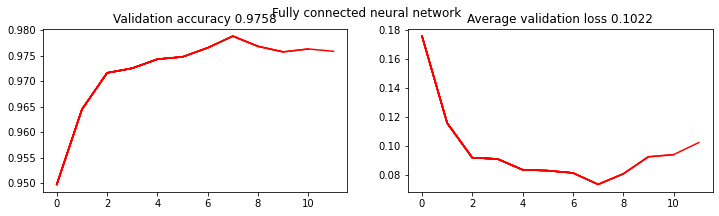

Epoch 13
-------------------------------
loss: 0.004677  [    0/52500]
loss: 0.007717  [12800/52500]
loss: 0.007835  [25600/52500]
loss: 0.000425  [38400/52500]
loss: 0.001454  [51200/52500]
INFO: Early stopping counter 5 of 5
INFO: Early stopping


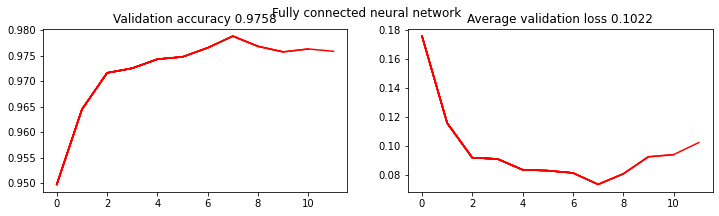

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

model_fcnn = NeuralNetwork().to(device)
print(model_fcnn)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fcnn.parameters(), lr=0.0005)
early_stop_callback = EarlyStopping()

fig, axs = plt.subplots(1,2, figsize=(12,3))
plt.suptitle('Fully connected neural network')
result = {'avg_loss':[], 'acc':[], 'epoch':[]}

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_fcnn, loss_fn, optimizer)
    test(val_dataloader, model_fcnn, loss_fn, result)
    result['epoch'].append(t)
    early_stop_callback(result['avg_loss'][-1])
    if early_stop_callback.early_stop:
        break
    plot_results(axs, result)

In [10]:
model = model_fcnn
dataloader = val_dataloader

size = len(dataloader.dataset)
num_batches = len(dataloader)
model.eval()
test_loss, correct = 0, 0

with torch.no_grad():
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

test_loss /= num_batches
correct /= size

test_loss, correct

(0.09349837647003197, 0.9781142857142857)

# Convolutional neural network

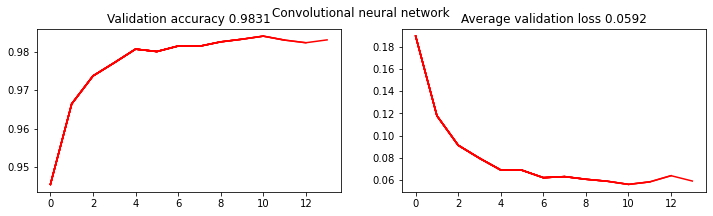

Epoch 15
-------------------------------
loss: 0.021736  [    0/52500]
loss: 0.005290  [12800/52500]
loss: 0.006799  [25600/52500]
loss: 0.019424  [38400/52500]
loss: 0.022862  [51200/52500]
INFO: Early stopping counter 5 of 5
INFO: Early stopping


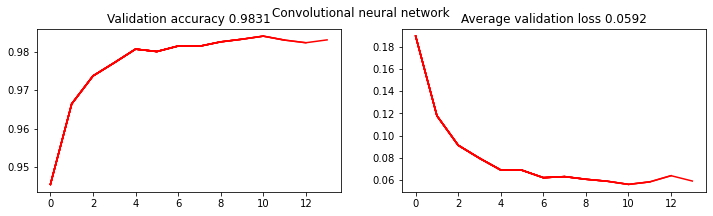

In [11]:
training_data = CustomImageDataset(df_train, model_type='cnn')
val_data = CustomImageDataset(df_val, model_type='cnn')
# create Dataloader for cnn
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

model_cnn = CNN().to(device)
print(model_cnn)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.0005)
early_stop_callback = EarlyStopping()

fig, axs = plt.subplots(1,2, figsize=(12,3))
plt.suptitle('Convolutional neural network')
result = {'avg_loss':[], 'acc':[], 'epoch':[]}

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_cnn, loss_fn, optimizer)
    test(val_dataloader, model_cnn, loss_fn, result)
    result['epoch'].append(t)
    early_stop_callback(result['avg_loss'][-1])
    if early_stop_callback.early_stop:
        break
    plot_results(axs, result)

In [12]:
model = model_cnn
dataloader = val_dataloader

size = len(dataloader.dataset)
num_batches = len(dataloader)
model.eval()
test_loss, correct = 0, 0

with torch.no_grad():
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

test_loss /= num_batches
correct /= size

test_loss, correct

(0.05900802748128228, 0.9834285714285714)

# FGSM using CNN

In [13]:
def fgsm_attack(x_original, epsilon, gradient):
    # Get Gradient sign
    grad_sign = gradient.sign()
    # Add epsilon*grad_sign perturbation to the original input
    perturbation = epsilon*grad_sign
    x_perturbed = x_original + perturbation
    return x_perturbed, perturbation

In [14]:
epsilons = torch.Tensor([0.01, 0.03, 0.07, 0.1])
acc_results_non = dict()
verbose = False
N_VAL_SAMPLES = 17500
model_cnn.eval()

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 8, kernel_size=(2, 2), stride=(1, 1))
  (relu2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [15]:
validation_dataloader = DataLoader(valid_data, batch_size=1, shuffle=False)

17500it [00:31, 554.04it/s]


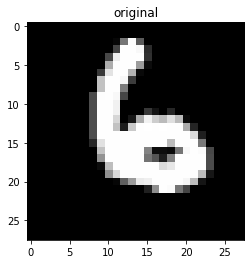

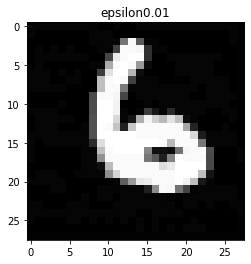


FGSM Attack with epsilon = 0.01000 | Elapsed time: 31.80 seconds.
Accuracy: Before the attack -> 98.34%	|	After the attack -> 96.51%


17500it [00:29, 583.49it/s]


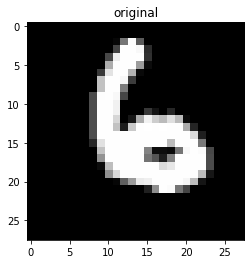

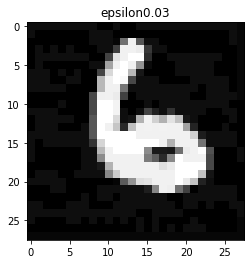


FGSM Attack with epsilon = 0.03000 | Elapsed time: 30.19 seconds.
Accuracy: Before the attack -> 98.34%	|	After the attack -> 86.26%


17500it [00:31, 561.67it/s]


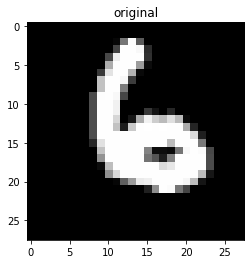

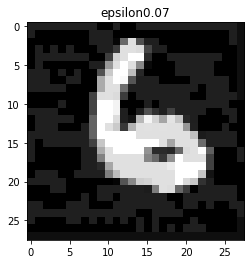


FGSM Attack with epsilon = 0.07000 | Elapsed time: 31.35 seconds.
Accuracy: Before the attack -> 98.34%	|	After the attack -> 40.13%


17500it [00:30, 579.50it/s]


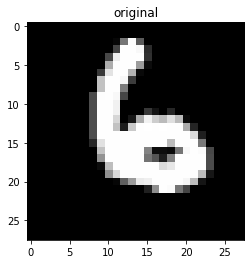

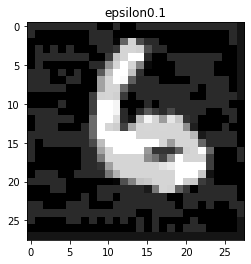


FGSM Attack with epsilon = 0.10000 | Elapsed time: 30.39 seconds.
Accuracy: Before the attack -> 98.34%	|	After the attack -> 16.03%


In [16]:
import time
from tqdm import tqdm
criterion = nn.CrossEntropyLoss()

attack_sample = {'0.01':torch.zeros(17500, 28, 28),
                 '0.03':torch.zeros(17500, 28, 28),
                 '0.07':torch.zeros(17500, 28, 28),
                 '0.1':torch.zeros(17500, 28, 28)}

for eps in epsilons:
    correct_unperturbed = 0
    correct_perturbed = 0
    t0 = time.perf_counter()
    
    attack = torch.zeros(17500, 28, 28)
    label = torch.zeros(17500)
    for j, val_data in tqdm(enumerate(validation_dataloader, 0)):
        ### NOTE: IT WOULD BE MORE EFFICIENT TO ITERATE ONLY ONCE THROUGH THE DATA AND PERFORM ALL THE ATTACKS
        x, y_target = val_data
        x, y_target = x.to(device), y_target.to(device)
        x.requires_grad = True
        x = x.reshape(-1, 1, 28, 28)
        output = model_cnn(x)
        y_pred = torch.argmax(output)
        
        if y_pred == y_target:
            correct_unperturbed += 1
        # Calculate loss and gradient
        loss = criterion(output, y_target)
        grad = torch.autograd.grad(outputs=loss, inputs=x)[0]
        model_cnn.zero_grad()
        perturbed_x, _ = fgsm_attack(x, epsilon=eps, gradient=grad)
        perturbed_output = model_cnn(perturbed_x)
        y_pred_perturbed = torch.argmax(perturbed_output)
        loss_perturbed = criterion(perturbed_output, y_target)
        if y_pred_perturbed == y_target:
            correct_perturbed += 1

        attack[j] = perturbed_x
        label[j] = y_target
        
    if eps == 0.1:
        attack_sample['0.1'] = attack
    elif eps == 0.07:
        attack_sample['0.07'] = attack
    elif eps == 0.03:
        attack_sample['0.03'] = attack
    else:
        attack_sample['0.01'] = attack
    
    plt.imshow(x.detach().numpy().reshape(28, 28), cmap='gray')
    plt.title('original')
    plt.show()
    plt.imshow(perturbed_x.detach().numpy().reshape(28, 28), cmap='gray')
    plt.title('epsilon' + str(round(eps.item(), 3)))
    plt.show()
    
    acc_before_attack = correct_unperturbed / N_VAL_SAMPLES
    acc_after_attack = correct_perturbed / N_VAL_SAMPLES
    print(f'\nFGSM Attack with epsilon = {eps:.5f} | Elapsed time: {time.perf_counter() - t0:.2f} seconds.')
    print(f'Accuracy: Before the attack -> {100 * acc_before_attack:.2f}%\t|\tAfter the attack -> {100 * acc_after_attack:.2f}%')
    acc_results_non[eps.item()] = acc_after_attack
acc_results_non[0] = acc_before_attack

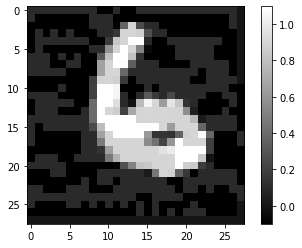

In [17]:
plt.imshow(attack[-1].detach().numpy().reshape(28, 28), cmap='gray')
plt.colorbar()

In [18]:
import pickle 

data = {'data' : attack_sample,
        'label' : label}

with open('MNIST_FGSM_CNN.pickle', 'wb') as f:
    pickle.dump(data, f)